# Unscented Kalman Filter

The unscented kalman filter is an alternative approach to the extended kalman filter. Instead of linearizing the state transition model and measurement model to compute the probability distribution, the unscented kalman filter computes the posterior distribution using sigma points.

## Motion Models

In the extended Kalman filter module we used one of the most basic motion models where we assumed that the objects were moving at constant velocity. In This section we will explore more advance motion models.

- Constant Turn Rate and Velocity Magnitude (CTRV)
- Constant Turn Rate and Acceleration (CTA)
- Constant Steering Angle and Velocity (CSAV)
- Constant Curvature and Acceleration (CCA)

All of the models can be used with a extended kalman filter or unscented kalman filter.

**Constant Turn Rate and Velocity Model**

This model uses velocity magnitude, yaw angle and yaw rate instead of the cartesian velocity. 

<img src='images/crtv_model.png'/>

The state vector is now represented as

$
x=
\begin{bmatrix}
p_x \\
p_y \\
v \\
\psi \\
\dot{\psi} \\
\end{bmatrix}
$

Now lets derive the state transition function that maps $x$ to $\dot{x}$.

$
\dot{x}=
\begin{bmatrix}
\dot{p}_x \\
\dot{p}_y \\
\dot{v} \\
\dot{\psi} \\
\ddot{\psi} \\
\end{bmatrix}
=
\begin{pmatrix}
v\cdot\cos(\psi) \\
v\cdot\sin(\psi) \\
0 \\
\dot{\psi} \\
0 \\
\end{pmatrix}
$

Since we are assuming constant turn rate this means that the lateral acceleration and radial accelerations are zero. To find the state transition matrix we now need to integrate $\dot{x}$ from $t_k$ to $t_{k+1}$.

$
x_{t_k + 1} = x_{t_k} + \int_{t_k}^{t_{k+1}} \dot{x}
=x_{t_k} + 
\begin{bmatrix}
\frac{v_k}{\dot{\psi}_k}(sin(\psi_k+\dot{\psi}_k \Delta t) - sin(\psi_k)) \\
\frac{v_k}{\dot{\psi}_k}(-cos(\psi_k+\dot{\psi}_k \Delta t) + cos(\psi_k)) \\
0 \\
\dot{\psi}_k \Delta t \\
0 \\
\end{bmatrix}
$

If the yaw rate is zero then the equation becomes

$
x_{t_k + 1} =
x_{t_k} + 
\begin{bmatrix}
v_k cos(\psi_k) \Delta t \\
v_k sin(\psi_k) \Delta t \\
0 \\
0 \\
0 \\
\end{bmatrix}
$

The state transition is composed of deterministic and stochastic components. In this case the model that we are using is the constant rate of turn with velocity magnitude (CRTV). We can compue the state transition function by finding $\dot{x}$ as shown above and integrating from $t_k$ to $t_{k+1}$. The resulting equation is the deterministic component for predicting state $x_{k+1}$.

The part we haven't included yet is the stochastic component. In this model we are assuming a constant turn rate which means we are assuming the longitudinal acceleration and yaw acceleration are zero. In reality this is not guaranteed to be the case so we are going to model these two parameters as random normal variables with mean, 0. Using these variables we can derive the state covariance matrix.

$
\begin{align}
\nu_{a,k} = \mathcal{N}(0, \sigma^2_{a}) \\
\nu_{\ddot{\psi},l} = \mathcal{N}(0, \sigma^2_{\ddot{\psi}})
\end{align}
$

Lets take a look at how the longitudinal acceleration and yaw acceleration affect the existing model. So the existing model is the following and we want to solve for a, b, c, d, and e using $\eta_{a,k}$ and $\eta_{\ddot{\psi},k}$.

$
x_{t_k + 1} =
x_{t_k} + 
\begin{bmatrix}
\frac{v_k}{\dot{\psi}_k}(sin(\psi_k+\dot{\psi}_k \Delta t) - sin(\psi_k)) \\
\frac{v_k}{\dot{\psi}_k}(-cos(\psi_k+\dot{\psi}_k \Delta t) + cos(\psi_k)) \\
0 \\
\dot{\psi}_k \Delta t \\
0 \\
\end{bmatrix}
+
\begin{bmatrix}
a \\
b \\
c \\
d \\
e \\
\end{bmatrix}
$

$
\begin{align}
a &= \frac{\Delta t^2}{2} cos(\psi_k)\nu_{a,k} \\
b &= \frac{\Delta t^2}{2} sin(\psi_k)\nu_{a,k} \\
c &= \Delta t \nu_{a,k} \\
d &= \frac{\Delta t^2}{2}\nu_{\ddot{\psi},k} \\
e &= \Delta t \nu_{\ddot{\psi},k} \\
\end{align}
$

We can now compute the process covariance, Q using the formula below

$
Q = [\nu_k \cdot \nu_k^T]
$

## Unscented Kalman Filter

The unscented kalman filter handles computing the posterior distribution when the process model or measurement model are nonlinear in a different way than the extended kalman filter. The main problem that is being addressed is the gaussian is not preserved when passed through a nonlinear function. The objective of the unscented kalman filter is to provide the best estimate of a gaussian that represents the true posterior distribution.

The way that it does this is by passing representative points of the original gaussian distribution through the nonlinear function and then computing the covariance of those points. These points are called sigma points. 

**UKF Flow**
- Prediction
    * Generate sigma points
    * Predict sigma points
    * Predict Mean and Covariance
- Update
    * Predict Measurement
    * Update state
    
<img src='images/generating_sigma_points.png'/>

To compute the sigma points the following formula is used

$
X_{k|K} = 
\begin{bmatrix}
x_{k|k} & x_{k|k} + \sqrt{(\lambda + n_x)P_{k|k}} & x_{k|k} - \sqrt{(\lambda + n_x)P_{k|k}}
\end{bmatrix}
$

The $\lambda$ term is a design parameter and adjust the spread of the sigma points. Imagine each column of P and lambda is a scalar multiplier applied to that. A common choice is to set 

$
\lambda = 3 - n_x
$

Below is an implementation in python of a sigma point generator. This can be easily transfered to C++ in the project. I will be using the same parameters that were presented in the module for the state vector and belief covariance.

In [ ]:
import numpy as np

# state vector
x = np.array([5.7441, 1.3800, 2.2049, 0.5015, 0.3528])
x = x[np.newaxis].T

# state vector length
nx = x.shape[0]

# lambda
l = 3 - nx

print("x=\n{}".format(x))

P = np.array([[0.0043,   -0.0013,    0.0030,   -0.0022,   -0.0020,],
              [-0.0013,    0.0077,    0.0011,    0.0071,    0.0060,],
              [0.0030,    0.0011,    0.0054,    0.0007,    0.0008,],
              [-0.0022,    0.0071,    0.0007,    0.0098,    0.0100,],
              [-0.0020,    0.0060,    0.0008,    0.0100,    0.0123]])

print("P=\n{}".format(P))

# sqrt of P
A = np.linalg.cholesky(P)

# sigma points
X = np.zeros((5,11), dtype=np.double)
X = np.asmatrix(X)

# compute sigma point array
X[:,0] = x
X[:,1:nx+1] = x + np.sqrt(l + nx)*A
X[:,-nx:] = x - np.sqrt(1 + nx)*A

print("X=\n{}".format(X))

There is one thing missing now. We need to incorporate the the process model noises in our belief, $\nu_a$ and $\nu_{\dot{\psi}}$. To do this we are going to augment the state vector and covariance matrix to include the process model noise parameters.

$
x_{a}=
\begin{bmatrix}
p_x \\
p_y \\
v \\
\psi \\
\dot{\psi} \\
\nu_a \\
\nu_{\ddot{\psi}} \\
\end{bmatrix}
$

and 

$
P_{a} =
\begin{bmatrix}
P & 0 \\
0 & Q \\
\end{bmatrix}
$

where Q is

$ 
Q=
\begin{bmatrix}
\sigma^2_a & 0 \\
0 & \sigma^2_{\ddot{\psi}} \\
\end{bmatrix}
$

Now that we have compute the sigma points at k, we need to predict where the sigma points will be in k+1 by using the prediction equation with each sigma point as input. For reference the state prediction equations are the following

$
x_{t_k + 1} = x_{t_k} + \int_{t_k}^{t_{k+1}} \dot{x}
=x_{t_k} + 
\begin{bmatrix}
\frac{v_k}{\dot{\psi}_k}(sin(\psi_k+\dot{\psi}_k \Delta t) - sin(\psi_k)) \\
\frac{v_k}{\dot{\psi}_k}(-cos(\psi_k+\dot{\psi}_k \Delta t) + cos(\psi_k)) \\
0 \\
\dot{\psi}_k \Delta t \\
0 \\
\end{bmatrix}
$

If the yaw rate is zero then the equation becomes

$
x_{t_k + 1} =
x_{t_k} + 
\begin{bmatrix}
v_k cos(\psi_k) \Delta t \\
v_k sin(\psi_k) \Delta t \\
0 \\
0 \\
0 \\
\end{bmatrix}
$

After computing the predicted sigma points by passing the points through the state transition function we need to compute the updated belief covariance. To do this we use the following equations

<img src="images/predicted_covariance.png"/>

This completes the prediction update step for the unscented kalman filter. Now we must perform the measurement update. The process is very similar. 

To do the measurement update we are going to use the predicted sigma points generated by the prediction step. These will be passed through the measurement function and the measurement covariance will be computed using the transformed points. In this case the sensor noise is purely additive so we don't need to worry about the sensor covariance when doing this step.

<img src="images/measurement_covariance.png"/>

Now that we have the predicted measurement and measurement covariance all we need to is compute the new state and covariance using the standard kalman filter equations with a minor update. The kalman gain is computed using a cross corelation between the measurement and state covariance.

<img src="images/measurement_update.png"/>

In [7]:
import numpy as np
import pandas as pd

state_output = 'cmake-build-debug/state_output.txt'
state_cov_output = 'cmake-build-debug/state_cov_output.txt'
general_output = 'cmake-build-debug/output.txt'

# parse state output
with open(state_output, "r") as f:
    lines = f.readlines()
    estimates = np.zeros((5, len(lines)), dtype=np.double)
    for i, line in enumerate(lines):
        state = eval(line.replace("nan", "np.nan"))
        estimates[:, i] = np.array(state, dtype=np.double).flatten()

# parse state covariance output
with open(state_cov_output, "r") as f:
    lines = f.readlines()
    estimate_covs = np.zeros((len(lines), 5, 5))
    for i, line in enumerate(lines):
        state_cov = eval(line.replace("nan", "np.nan").replace("inf", "np.inf"))
        estimate_covs[i, :, :] = np.array(state_cov, dtype=np.double)
        
summary = pd.read_table(general_output).dropna()

print(len(summary.index))

np.diff(summary.px_state), np.diff(summary.py_state)

3


(array([ 12.31458,  30.2204 ]), array([ 0.354268,  0.80384 ]))

In [95]:
import matplotlib.pyplot as plt

for i in range(len(summary.index)):
    cov = estimate_covs[i,:,:]
    print(np.linalg.eig(cov)[0])

[ 0.09    0.09    0.09    0.0009  0.01  ]
[ 0.09461365  0.08561152  0.09002107  0.00089733  0.01002743]
[ 0.08889974  0.18207684  0.18003466  0.00165445  0.0102694 ]
[ 0.36499869  0.3601611   0.08793734  0.0116121   0.00240827]
[ 0.73381708  0.72075752  0.08448848  0.01680681  0.0016401 ]
[ 1.47766063  1.44273091  0.07357219  0.02996519 -0.00223693]


In [92]:
P = np.array(
    [[0.11, 0.00081589, 0.22311, 0.00022544, 0.00014802, 0, 0], 
     [0.00051589, 1.4439, 0.0064186, -0.0078363, -0.0051452, 0, 0], 
     [0.22311, 0.0064186, 1.44, 3.5304e-18, -1.0164e-19, 0, 0], 
     [0.00022544, -0.0078363, 3.5304e-18, 0.017792, 0.015655, 0, 0], 
     [0.00014802, -0.0051452, -1.0164e-19, 0.015655, 0.01, 0, 0],
     [0, 0, 0, 0, 0, 1e-10, 0], 
     [0, 0, 0, 0, 0, 0, 1e-10]]
)

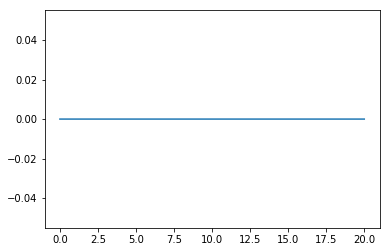

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def predict(x, P):
    nx = 5
    na = 7
    ns = 2 * na + 1
    
    l = 3 - na
    

def process_model(x, dt):
    """
    CRTV process model. Compute state x at time k + 1
    
    Arguments:
        x: augmented state vector
        dt: time in seconds
    """
    px, py, vm, yaw, yawd, am, yawdd = x
    x_pred = np.copy(x)
    
    if yawd < 0.001:
        x_pred[0] += vm * np.cos(yaw) * dt
        x_pred[1] += vm * np.sin(yaw) * dt
    else:
        x_pred[0] += (vm/yawd) * (np.sin(yaw + yawd * dt) - np.sin(yaw))
        x_pred[1] += (vm/yawd) * (np.cos(yaw) - np.cos(yaw + yawd * dt))
        x_pred[3] += yawd * dt
        
    x_pred[0] += 0.5 * dt ** 2 * np.cos(yaw) * am
    x_pred[1] += 0.5 * dt ** 2 * np.sin(yaw) * am
    x_pred[2] += dt * am
    x_pred[3] += 0.5 * dt ** 2 * yawdd
    x_pred[4] += dt * yawdd
    
    x_pred[3] = np.tan()
        
    return x_pred

x = np.array(
    [0, 0, 1, 0, 0, 0, 0], dtype=np.double
).reshape((7,1))

trajectory = np.zeros((7, 2000))
for i in range(2000):
    trajectory[:, i] = x.flatten()
    x = process_model(x, 0.01)

plt.figure()
plt.plot(trajectory[0, :], trajectory[1, :])
plt.show()

(0.0, 2.0)